**Important**:
Follow the instructions below when submitting your attempt.
Submissions not following these instructions will not be graded.

1. **Use JupyterLab**. Other notebook-editing software (e.g. VSCode, pycharm) might corrupt the notebook files.
3. **Do not remove, modify or duplicate** any given cells, except those in which you need to fill in your implementation. You can add new cells in order to present additional texts or plots.
4. **Restart the kernel and re-run the whole notebook** once before submission. After this step, the cell id should be incremental from top to bottom, and all plots should be displayed.
5. **Submit only the `.ipynb` files**, do not upload archives (zip, rar, tar, etc.), images or datasets.
6. **Do not change the filenames** of the `.ipynb` files.

# Vision Models

Building on top of the previous exercise, we will now implement more sophisticated models for image classification, namely a ResNet and a Vision Transformer.
Augmented training data and a function for training is provided, so we can focus on building these models.

In [1]:
LOG_ROOT = 'tensorboard_logs'
USE_GPU = False  # Set to True if you have installed tensorflow for GPU

In [2]:
USE_GPU = True  # Set to True if you have installed tensorflow for GPU

In [3]:
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid

# Just an image plotting function
def plot_multiple(images, titles=None, colormap='gray',
                  max_columns=np.inf, imwidth=2, imheight=2, share_axes=False):
    """
    Plot multiple images as subplots on a grid. Images must be channel-first
    and between [0, 1].
    """
    images = [np.transpose(im, (1, 2, 0)) for im in images]
    if titles is None:
        titles = [''] * len(images)
    assert len(images) == len(titles)
    n_images = len(images)
    n_cols = min(max_columns, n_images)
    n_rows = int(np.ceil(n_images / n_cols))
    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(n_cols * imwidth, n_rows * imheight),
        squeeze=False, sharex=share_axes, sharey=share_axes)

    axes = axes.flat
    # Hide subplots without content
    for ax in axes[n_images:]:
        ax.axis('off')
        
    if not isinstance(colormap, (list,tuple)):
        colormaps = [colormap]*n_images
    else:
        colormaps = colormap

    for ax, image, title, cmap in zip(axes, images, titles, colormaps):
        ax.imshow(image, cmap=cmap)
        ax.set_title(title)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    fig.tight_layout()
    
def visualize_dataset(dataset, n_samples=24, max_columns=6):
    xs, ys = list(zip(*[dataset[i] for i in range(n_samples)]))
    plot_multiple([x / 2 + 0.5 for x in xs], [labels[i] for i in ys], max_columns=max_columns)

def train_model(
    model,
    criterion,
    opt,
    logdir,
    train_loader,
    test_loader,
    n_epochs=50,
    lr_scheduler=None,
):
    # stuff for writing to tensorboard
    writer = SummaryWriter(f"{LOG_ROOT}/{logdir}-{time.strftime('%y%m%d_%H%M%S')}")
    layout = {
        'Losses': {'losses': ['Multiline', ['loss/train', 'loss/test']]},
        'Accuracy': {'accuracy': ['Multiline', ['accuracy/train', 'accuracy/test']]}
    }
    writer.add_custom_scalars(layout)
    
    start = time.time()  # get current time for statistics
    for epoch in range(n_epochs):  # iterate over epochs
        model.train()  # set the model to training mode
        # collect some numbers for statistics
        sample_count = 0  # number of seen samples
        loss_sum = 0  # total loss
        correct_count = 0  # total number of correctly classified samples
        n_batches = len(train_loader)  # number of batches
        for i, (xs, ys) in enumerate(train_loader):  # iterate over training set
            # training step
            if USE_GPU:
                xs = xs.cuda()
                ys = ys.cuda()
            out = model(xs)
            loss = criterion(out, ys)
            loss.backward()
            opt.step()
            opt.zero_grad()

            # update statistics
            loss_sum += loss.item() * xs.shape[0]
            _, pred = torch.max(out, 1)
            correct_count += (pred == ys).sum().item()
            sample_count += xs.shape[0]
            print(f'Train epoch {epoch+1}, step {i+1}/{n_batches}', end='    \r')

        if lr_scheduler is not None:
            lr_scheduler.step()

        train_loss = loss_sum / sample_count
        train_accuracy = correct_count / sample_count
        
        with torch.no_grad():  # do not store gradients during testing, decreases memory consumption
            model.eval()  # set the model to evaluation mode
            sample_count = 0
            loss_sum = 0
            correct_count = 0
            n_batches = len(test_loader)
            for i, (xs, ys) in enumerate(test_loader):
                if USE_GPU:
                    xs = xs.cuda()
                    ys = ys.cuda()
                out = model(xs)
                loss = criterion(out, ys)
                loss_sum += loss.item() * xs.shape[0]
                _, pred = torch.max(out, 1)
                correct_count += (pred == ys).sum().item()
                sample_count += xs.shape[0]
                print(f'Test epoch {epoch+1}, step {i+1}/{n_batches}', end='    \r')
                
            test_loss = loss_sum / sample_count
            test_accuracy = correct_count / sample_count
        
        writer.add_scalar('loss/train', train_loss, epoch+1)
        writer.add_scalar('accuracy/train', train_accuracy, epoch+1)
        writer.add_scalar('loss/test', test_loss, epoch+1)
        writer.add_scalar('accuracy/test', test_accuracy, epoch+1)
            
        print(
            f'Epoch {epoch+1} | train loss: {train_loss:.3f}, train accuracy: {train_accuracy:.3f}, ' + \
            f'test loss: {test_loss:.3f}, test accuracy: {test_accuracy:.3f}, ' + \
            f'time: {str(datetime.timedelta(seconds=int(time.time()-start)))}'
        )

In [4]:
normalize_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

augment_transform = transforms.Compose([
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomHorizontalFlip()
])

train_data = CIFAR10(root='cifar10/train/', train=True, download=True, transform=transforms.Compose([augment_transform, normalize_transform]))
test_data = CIFAR10(root='cifar10/test/', train=False, download=True, transform=normalize_transform)
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=6)
test_loader = DataLoader(test_data, batch_size=128, num_workers=6)

Files already downloaded and verified
Files already downloaded and verified


## The Simple CNN

As a starting point we use the CNN you already know from the previous exercise.

In [5]:
cnn = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(in_features=4096, out_features=10)
)
if USE_GPU:
    cnn.cuda()

train_model(
    model=cnn,
    criterion=nn.CrossEntropyLoss(),
    opt=optim.Adam(cnn.parameters(), lr=5e-4),
    logdir='cnn',
    train_loader=train_loader,
    test_loader=test_loader
)

Epoch 1 | train loss: 1.615, train accuracy: 0.422, test loss: 1.326, test accuracy: 0.533, time: 0:01:04
Epoch 2 | train loss: 1.335, train accuracy: 0.526, test loss: 1.162, test accuracy: 0.589, time: 0:02:13
Epoch 3 | train loss: 1.221, train accuracy: 0.570, test loss: 1.059, test accuracy: 0.635, time: 0:03:20
Epoch 4 | train loss: 1.135, train accuracy: 0.602, test loss: 0.993, test accuracy: 0.655, time: 0:04:32
Epoch 5 | train loss: 1.076, train accuracy: 0.623, test loss: 0.946, test accuracy: 0.672, time: 0:05:41
Epoch 6 | train loss: 1.034, train accuracy: 0.641, test loss: 0.928, test accuracy: 0.682, time: 0:06:57
Epoch 7 | train loss: 1.002, train accuracy: 0.651, test loss: 0.912, test accuracy: 0.687, time: 0:08:09
Epoch 8 | train loss: 0.972, train accuracy: 0.662, test loss: 0.872, test accuracy: 0.705, time: 0:09:18
Epoch 9 | train loss: 0.948, train accuracy: 0.673, test loss: 0.848, test accuracy: 0.709, time: 0:10:26
Epoch 10 | train loss: 0.927, train accuracy: 

## Batch Normalization

Batch normalization is a technique to improve and speed up the training of deep neural networks. Each feature channel is normalized to have zero mean and unit variance across the spatial and mini-batch axes. To compensate for the lost degrees of freedom, extra scaling and bias parameters are introduced and learned. Mathematically, BatchNorm for a spatial feature map (e.g. the output of conv) can be written as:

$$
\mu_d = \mathbb{E}\{x_{\cdot \cdot d}\}, \\
\sigma_d = \sqrt{\operatorname{Var}\{x_{\cdot \cdot d}\}} \\
z_{ijd} = \gamma_d \cdot \frac{x_{ijd} - \mu_d}{\sigma_d} + \beta_d,\\
$$

with the expectation and variance taken across both the data samples of the batch and the spatial dimensions.

The $\mu_d$ and $\sigma_d$ values are computed on the actual mini-batch during training, but at test-time they are fixed, so that the prediction of the final system on a given sample does not depend on other samples in the mini-batch. To obtain the fixed values for test-time use, one needs to maintain moving statistics over the activations during training. This can be a bit tricky to implement from scratch, but luckily this is now implemented in all popular frameworks, including PyTorch.

When applying BatchNorm, it is not necessary to use biases in the previous convolutional layer. Why?

*POINTS: 1*

YOUR ANSWER HERE

Create a modified version of the previous model using batch normalization between each convolution and the corresponding activation. Use the `bias` argument of `nn.Conv2d` according to the above finding.

In [6]:
# POINTS: 3

cnn_batchnorm = nn.Sequential(
    # YOUR CODE HERE
    # raise NotImplementedError()
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(in_features=256*4*4, out_features=512),  # Adjust based on input size and pooling
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=10)
)
if USE_GPU:
    cnn_batchnorm.cuda()

train_model(
    model=cnn_batchnorm,
    criterion=nn.CrossEntropyLoss(),
    opt=optim.Adam(cnn_batchnorm.parameters(), lr=5e-4),
    logdir='cnn_batchnorm',
    train_loader=train_loader,
    test_loader=test_loader
)

Epoch 1 | train loss: 1.386, train accuracy: 0.497, test loss: 1.028, test accuracy: 0.636, time: 0:01:40
Epoch 2 | train loss: 0.970, train accuracy: 0.658, test loss: 0.951, test accuracy: 0.669, time: 0:03:19
Epoch 3 | train loss: 0.843, train accuracy: 0.702, test loss: 0.787, test accuracy: 0.719, time: 0:04:56
Epoch 4 | train loss: 0.764, train accuracy: 0.730, test loss: 0.678, test accuracy: 0.759, time: 0:06:34
Epoch 5 | train loss: 0.697, train accuracy: 0.755, test loss: 0.722, test accuracy: 0.749, time: 0:08:12
Epoch 6 | train loss: 0.652, train accuracy: 0.770, test loss: 0.644, test accuracy: 0.777, time: 0:09:51
Epoch 7 | train loss: 0.621, train accuracy: 0.783, test loss: 0.653, test accuracy: 0.773, time: 0:11:31
Epoch 8 | train loss: 0.594, train accuracy: 0.791, test loss: 0.599, test accuracy: 0.792, time: 0:13:09
Epoch 9 | train loss: 0.557, train accuracy: 0.805, test loss: 0.593, test accuracy: 0.794, time: 0:14:46
Epoch 10 | train loss: 0.538, train accuracy: 

## Strided Convolutions

Max-pooling is a popular technique for reducing the spatial dimensionality
of the outputs from conv layers. Another way to reduce dimensionality is striding. For an argument why this may be similarly effective, see [Springenberg et al., ICLRW'15](https://arxiv.org/pdf/1412.6806.pdf).

Now create a model using the same architecture as before, with the difference of
removing the max-pooling layers and increasing the stride parameter of the conv layers to $2 \times 2$ in the spatial dimensions. 

In [7]:
# POINTS: 2

cnn_strides = nn.Sequential(
    # YOUR CODE HERE
    # raise NotImplementedError()
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=256*4*4, out_features=512),  # Adjust based on input size and pooling
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=10)
)
if USE_GPU:
    cnn_strides.cuda()

train_model(
    model=cnn_strides,
    criterion=nn.CrossEntropyLoss(),
    opt=optim.Adam(cnn_strides.parameters(), lr=5e-4),
    logdir='cnn_strides',
    train_loader=train_loader,
    test_loader=test_loader
)

Epoch 1 | train loss: 1.637, train accuracy: 0.404, test loss: 1.339, test accuracy: 0.508, time: 0:01:04
Epoch 2 | train loss: 1.328, train accuracy: 0.522, test loss: 1.181, test accuracy: 0.576, time: 0:02:08
Epoch 3 | train loss: 1.189, train accuracy: 0.575, test loss: 1.069, test accuracy: 0.620, time: 0:03:12
Epoch 4 | train loss: 1.082, train accuracy: 0.612, test loss: 0.995, test accuracy: 0.643, time: 0:04:17
Epoch 5 | train loss: 1.003, train accuracy: 0.644, test loss: 0.957, test accuracy: 0.662, time: 0:05:22
Epoch 6 | train loss: 0.936, train accuracy: 0.668, test loss: 0.890, test accuracy: 0.685, time: 0:06:26
Epoch 7 | train loss: 0.879, train accuracy: 0.690, test loss: 0.837, test accuracy: 0.708, time: 0:07:31
Epoch 8 | train loss: 0.838, train accuracy: 0.704, test loss: 0.793, test accuracy: 0.727, time: 0:08:35
Epoch 9 | train loss: 0.791, train accuracy: 0.722, test loss: 0.773, test accuracy: 0.734, time: 0:09:39
Epoch 10 | train loss: 0.748, train accuracy: 

What differences do you notice when training this new network?
What is a clear advantage of using strides?

*POINTS: 1*

YOUR ANSWER HERE

Using strides can speed up training and reduce memory usage, but careful design is needed to maintain performance.

## Global Pooling

The above network ends in a `Flatten` layer followed by a `Linear` layer, in which the number of weights depends on the input size. This means that testing can only be performed on the exact same image size. Several architectures employ a (spatial) **global average pooling layer** to produce a vector of fixed size describing the whole image.

Implement the forward pass of such a layer below. The input `x` has size `[batch_size, channels, height, width]`. The mean must be computed across the last two dimensions, such that the result `pooled` has a size of `[batch_size, channels]`. Note, that you cannot use numpy for this as PyTorch is not able to backpropagate through numpy functions. There are however corresponding PyTorch functions for almost all numpy functions.

This layer can now replace the flattening operation from the previous network. However, the units before the average pooling need to have a large enough receptive field, otherwise the model will not work well. Therefore, compared with the previous model, remove the `Flatten` layer and instead add a third Conv-BatchNorm-ReLU combination. Then add `GlobalAvgPool2d` and a final `Linear` layer which returns $10$ values per sample instead of $64$.

Train it and see if it reaches similar accuracy to the previous one.

In [8]:
# POINTS: 4

class GlobalAvgPool2d(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # YOUR CODE HERE
        # raise NotImplementedError()
        pooled = torch.mean(x, dim=[2, 3])
        return pooled


cnn_global_pool = nn.Sequential(
    # YOUR CODE HERE
    # raise NotImplementedError()
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
    nn.ReLU(),
    GlobalAvgPool2d(),  # Apply Global Average Pooling
    nn.Linear(in_features=256, out_features=10)
)
if USE_GPU:
    cnn_global_pool.cuda()

train_model(
    model=cnn_global_pool,
    criterion=nn.CrossEntropyLoss(),
    opt=optim.Adam(cnn_global_pool.parameters(), lr=5e-4),
    logdir='cnn_global_pool',
    train_loader=train_loader,
    test_loader=test_loader
)

Epoch 1 | train loss: 1.915, train accuracy: 0.277, test loss: 1.730, test accuracy: 0.346, time: 0:02:42
Epoch 2 | train loss: 1.735, train accuracy: 0.347, test loss: 1.760, test accuracy: 0.344, time: 0:05:29
Epoch 3 | train loss: 1.656, train accuracy: 0.387, test loss: 1.656, test accuracy: 0.382, time: 0:08:24
Epoch 4 | train loss: 1.579, train accuracy: 0.421, test loss: 1.523, test accuracy: 0.449, time: 0:11:25
Epoch 5 | train loss: 1.515, train accuracy: 0.453, test loss: 1.491, test accuracy: 0.456, time: 0:14:24
Epoch 6 | train loss: 1.466, train accuracy: 0.472, test loss: 1.429, test accuracy: 0.484, time: 0:17:23
Epoch 7 | train loss: 1.425, train accuracy: 0.485, test loss: 1.408, test accuracy: 0.495, time: 0:20:22
Epoch 8 | train loss: 1.385, train accuracy: 0.502, test loss: 1.388, test accuracy: 0.505, time: 0:23:18
Epoch 9 | train loss: 1.348, train accuracy: 0.517, test loss: 1.328, test accuracy: 0.522, time: 0:26:09
Epoch 10 | train loss: 1.319, train accuracy: 

Which network has more parameters, this or the previous one?

What is the size of the receptive field of the units in the layer directly before the global average pooling? (Remember: the receptive field of a particular unit (neuron) is the area of the *input image* that can influence the activation of this given unit).

*POINTS: 2*

YOUR ANSWER HERE

The previous one has more parameters, and the size of the receptive field is 7 × 7

## Residual Networks

ResNet was introduced by [He et al. in 2016](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf) and is still popular today.

It consists of blocks like the following:

![ResNet Block](resnet_block.png)

Each of these so-called *residual blocks* only have to predict a *residual* (in plain words: the "rest", the "leftover") that will be added on top of its input.
In other words, the block outputs how much each feature needs to be changed in order to enhance the representation compared to the previous block.

There are several ways to combine residual blocks into *residual networks* (ResNets). In the following, we consider ResNet-v1, as used for the CIFAR-10 benchmark in the original ResNet paper (it is simpler compared to the full model that they used for the much larger ImageNet benchmark).

Section 4.2. of the paper describes this architecture as follows: "*The first layer is 3×3 convolutions. Then we use a stack of 6n layers with 3×3 convolutions on the feature maps of sizes {32, 16, 8} respectively, with 2n layers for each feature map size. The numbers of filters are {16, 32, 64} respectively. The subsampling is performed by convolutions with a stride of 2. The network ends with a global average pooling, a 10-way fully-connected layer, and softmax. [...] When shortcut connections are used, they are connected to the pairs of 3×3 layers (totally 3n shortcuts). On this dataset we use identity shortcuts in all cases.*"

Further, they use L2 regularization for training (a standard tool to combat overfitting). This penalizes weights with large magnitude by adding an additional term to the cost function, besides the cross-entropy. The overall function to optimize becomes:

$$
\mathcal{L}_{CE} + \frac{\lambda}{2} \sum_{w\in\text{weights}} w^2,
$$

and in this paper $\lambda=10^{-4}$.

Use the explanation above to complete the `layers`-list in the `ResNet`-class below. Note, that the first layer is already added and remember that the final softmax has to be omitted. The `ResNetBlock` already implements the above figure, i.e. contains $2$ convolutions.

Weight decay is already added by setting the corresponding attribute of the opimizer.

In [9]:
# POINTS: 6

class ResNetBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.f = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.activation = nn.ReLU()
        # The shortcut connection is just the identity. If feature
        # channel counts differ between input and output, zero
        # padding is used to match the depths. This is implemented
        # by a convolution with the following fixed weight:
        self.pad_weight = nn.Parameter(
            torch.eye(out_channels, in_channels)[:, :, None, None],
            requires_grad=False
        )
        self.stride = stride

    def forward(self, x):
        r = self.f(x)
        # We apply the padding weight using torch.functional.conv2d
        # which allows us to use a custom weight matrix.
        x = F.conv2d(x, self.pad_weight, stride=self.stride)
        return self.activation(x + r)
    

class ResNet(torch.nn.Module):
    def __init__(self, num_layers=8, in_channels=3, out_features=10):
        super().__init__()
        if (num_layers - 2) % 6 != 0:
            raise ValueError('n_layers should be 6n+2')
        n = (num_layers - 2) // 6
        
        layers = []
        
        first_layer = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        
        layers.append(first_layer)

        # YOUR CODE HERE
        # raise NotImplementedError()
        # Create n blocks of 16 filters
        for i in range(n):
            layers.append(ResNetBlock(16, 16))
        
        # Create n blocks of 32 filters with downsampling at the start
        layers.append(ResNetBlock(16, 32, stride=2))
        for i in range(n-1):
            layers.append(ResNetBlock(32, 32))
        
        # Create n blocks of 64 filters with downsampling at the start
        layers.append(ResNetBlock(32, 64, stride=2))
        for i in range(n-1):
            layers.append(ResNetBlock(64, 64))
        
        # Global Average Pooling and Fully Connected Layer
        layers.append(nn.AdaptiveAvgPool2d((1, 1)))
        layers.append(nn.Flatten())
        layers.append(nn.Linear(64, out_features))
        
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

Train a Resnet with 8 layers on the CIFAR-10 dataset for 50 epochs. As a rough idea, it will take less than 15 minutes with a good GPU, but on a CPU it can take several hours.

In [10]:
resnet = ResNet()
if USE_GPU:
    resnet.cuda()

train_model(
    model=resnet,
    criterion=nn.CrossEntropyLoss(),
    opt=optim.Adam(resnet.parameters(), lr=5e-4, weight_decay=1e-4),
    logdir='resnet',
    train_loader=train_loader,
    test_loader=test_loader
)

Epoch 1 | train loss: 1.640, train accuracy: 0.407, test loss: 1.435, test accuracy: 0.475, time: 0:01:25
Epoch 2 | train loss: 1.305, train accuracy: 0.533, test loss: 1.211, test accuracy: 0.563, time: 0:02:52
Epoch 3 | train loss: 1.151, train accuracy: 0.590, test loss: 1.132, test accuracy: 0.585, time: 0:04:14
Epoch 4 | train loss: 1.050, train accuracy: 0.628, test loss: 1.073, test accuracy: 0.620, time: 0:05:37
Epoch 5 | train loss: 0.983, train accuracy: 0.653, test loss: 0.947, test accuracy: 0.659, time: 0:07:01
Epoch 6 | train loss: 0.935, train accuracy: 0.670, test loss: 0.924, test accuracy: 0.675, time: 0:08:22
Epoch 7 | train loss: 0.898, train accuracy: 0.683, test loss: 0.891, test accuracy: 0.682, time: 0:09:45
Epoch 8 | train loss: 0.865, train accuracy: 0.695, test loss: 0.955, test accuracy: 0.665, time: 0:11:08
Epoch 9 | train loss: 0.838, train accuracy: 0.708, test loss: 0.913, test accuracy: 0.677, time: 0:12:35
Epoch 10 | train loss: 0.808, train accuracy: 

## Learning Rate Decay

Learning rate decay reduces the learning rate as the training progresses. Use the same settings as in the previous experiment, but this time create a `MultiStepLR`-scheduler and decrease the learning rate twice by a factor of 10 each.

In [11]:
# POINTS: 2

resnet_decay = ResNet()
if USE_GPU:
    resnet_decay.cuda()

# YOUR CODE HERE
# raise NotImplementedError()
# Define the optimizer
opt = optim.Adam(resnet_decay.parameters(), lr=5e-4)

# Define the learning rate scheduler
sched = optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.1)

train_model(
    model=resnet_decay,
    criterion=nn.CrossEntropyLoss(),
    opt=opt,
    logdir='resnet_decay',
    train_loader=train_loader,
    test_loader=test_loader,
    lr_scheduler=sched
)

Epoch 1 | train loss: 1.655, train accuracy: 0.390, test loss: 1.446, test accuracy: 0.456, time: 0:01:22
Epoch 2 | train loss: 1.317, train accuracy: 0.526, test loss: 1.215, test accuracy: 0.563, time: 0:02:38
Epoch 3 | train loss: 1.155, train accuracy: 0.591, test loss: 1.101, test accuracy: 0.604, time: 0:03:54
Epoch 4 | train loss: 1.052, train accuracy: 0.626, test loss: 1.076, test accuracy: 0.619, time: 0:05:10
Epoch 5 | train loss: 0.975, train accuracy: 0.655, test loss: 1.022, test accuracy: 0.637, time: 0:06:26
Epoch 6 | train loss: 0.916, train accuracy: 0.677, test loss: 1.014, test accuracy: 0.640, time: 0:07:42
Epoch 7 | train loss: 0.879, train accuracy: 0.692, test loss: 0.894, test accuracy: 0.678, time: 0:08:58
Epoch 8 | train loss: 0.842, train accuracy: 0.706, test loss: 0.924, test accuracy: 0.685, time: 0:10:15
Epoch 9 | train loss: 0.808, train accuracy: 0.718, test loss: 0.887, test accuracy: 0.692, time: 0:11:31
Epoch 10 | train loss: 0.783, train accuracy: 

## Positional Encoding

After the ResNet, we will now have a look at a more recent architecture, the Vision Transformer by [Dosovitskiy et al., 2020](https://arxiv.org/pdf/2010.11929.pdf).
This model subdivides the image into patches and feeds these into a transformer.
A CNN knows the spatial relationships between features very well, but a transformer does not.
Without any further processing, each patch would become a token and each token would only differ by its contents, but would not differ due to the pixel positions.
This is not wanted of course, as the location in images matters.
For this reason, we need to add a positional encoding to the tokens, such that e.g. the patch in the top left always receives the same encoding and thus the model is able to gather features using positions.

If each token $i$ is represented by $d$ features, that the $j$-th value is defined as

$$
p_{i,j} = 
\begin{cases}
\sin\left(\frac{i}{10000^{\frac{j}{d}}}\right) & \; \text{if } j \text{ is even}\\
\cos\left(\frac{i}{10000^{\frac{j-1}{d}}}\right) & \; \text{if } j \text{ is odd}
\end{cases}
$$

To avoid recomputing this expression for every evaluation, we want to precompute it once for some $i$ and $j$.
If you implemented this correctly, each row of the image looks different from every other row.

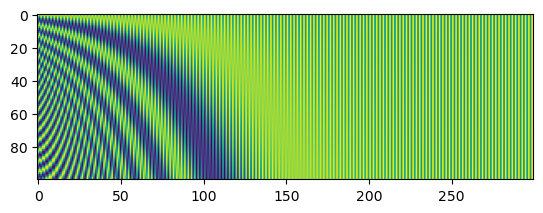

In [12]:
# POINTS: 2

POS_ENC_CACHE_T = 100
POS_ENC_CACHE_D = 300
pos_enc_cached = torch.zeros(POS_ENC_CACHE_T, POS_ENC_CACHE_D)
# YOUR CODE HERE
# raise NotImplementedError()
# Generate positional encodings
# position = torch.arange(0, POS_ENC_CACHE_T, dtype=torch.float).unsqueeze(1)
# div_term = torch.exp(torch.arange(0, POS_ENC_CACHE_D, 2).float() * (-np.log(10000.0) / POS_ENC_CACHE_D))

# pos_enc_cached[:, 0::2] = torch.sin(position * div_term)
# pos_enc_cached[:, 1::2] = torch.cos(position * div_term)
position = torch.arange(0, POS_ENC_CACHE_T, dtype=torch.float).unsqueeze(1)
div_term = torch.exp(torch.arange(0, POS_ENC_CACHE_D, 2).float() * (-torch.log(torch.tensor(10000.0)) / POS_ENC_CACHE_D))

pos_enc_cached[:, 0::2] = torch.sin(position * div_term)
pos_enc_cached[:, 1::2] = torch.cos(position * div_term)

plt.imshow(pos_enc_cached)
plt.show()

Why do we use addition instad of concatenation?
E.g. instead of 300 image features added to 300 positional features, we coul concatenate 150 image features to 150 positional features.

*POINTS: 1*

YOUR ANSWER HERE

Using addition maintains the same dimensionality and parameter efficiency, simplifying the model design. Concatenation increases dimensionality and complexity, requiring more parameters and architectural adjustments.

The forward function of the following module receives tokens as input which have shape $(N \times T \times D)$, where $N$ is the batch size, $T$ the number of tokens and $D$ the number of features.
Complete the implementation by adding (not concatenating!) the correct part of the precomputed positional embedding to the tokens.

In [13]:
# POINTS: 1

class PositionalEncoding(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, tokens):
        # YOUR CODE HERE
        # raise NotImplementedError()
        # max_len, d_model = tokens.size(0), tokens.size(2)
        
        # pe = torch.zeros(max_len, d_model, device=tokens.device)
        # position = torch.arange(0, max_len, dtype=torch.float, device=tokens.device).unsqueeze(1)
        # div_term = torch.exp(torch.arange(0, d_model, 2).float().to(tokens.device) * (-torch.log(torch.tensor(10000.0).to(tokens.device)) / d_model))

        # pe[:, 0::2] = torch.sin(position * div_term)
        # pe[:, 1::2] = torch.cos(position * div_term)

        # pe = pe.unsqueeze(1)  # Add batch dimension

        # return tokens + pe[:tokens.size(0), :]
        batch_size, seq_len, d_model = tokens.size()
        
        pe = torch.zeros(seq_len, d_model, device=tokens.device)
        position = torch.arange(0, seq_len, dtype=torch.float, device=tokens.device).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float().to(tokens.device) * (-torch.log(torch.tensor(10000.0).to(tokens.device)) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0).expand(batch_size, -1, -1)  # Add batch dimension

        return tokens + pe

        # seq_len = tokens.size(1)
        # return tokens + self.pos_encoding[:seq_len, :]

In [14]:
class Embedding(nn.Module):
    def __init__(self, im_shape, patch_size, out_dim):
        super().__init__()
        assert (
            im_shape[1] % patch_size[0] == 0
        ), "image height has to be divisible by patch height"
        assert (
            im_shape[2] % patch_size[1] == 0
        ), "image width has to be divisible by patch width"

        self.patch_size = patch_size
        self.input_dim = int(im_shape[0] * patch_size[0] * patch_size[1])  # size of a flattened patch
        self.out_dim = out_dim

        self.linear_mapper = nn.Linear(self.input_dim, self.out_dim)  # embeds a patch into a vector
        self.cls_token = nn.Parameter(torch.rand(1, self.out_dim))  # encodes the class at the end
        self.positional_encoding = PositionalEncoding()

    def patchify(self, images):
        num_patches = (images.shape[2] // self.patch_size[0]) * (
            images.shape[3] // self.patch_size[1]
        )

        split_H = images.unfold(2, self.patch_size[0], self.patch_size[0])
        split_HW = split_H.unfold(3, self.patch_size[1], self.patch_size[1])
        reordered = split_HW.permute(0, 2, 3, 1, 4, 5)
        reshaped = reordered.reshape(images.size(0), num_patches, -1)
        return reshaped

    def forward(self, images):
        patches = self.patchify(images)  # convert image to patches


        tokens = self.linear_mapper(patches)  # embed patches

        # add classification token to every sample of the batch
        tokens = torch.stack(
            [torch.vstack((self.cls_token, tokens[i])) for i in range(len(tokens))]
        )

        tokens = self.positional_encoding(tokens)

        return tokens

The function `patchify` takes images of shape $(N \times C \times H \times W)$ as input and outputs tokens of shape $(N \times T \times D)$.
Using $H_p$ and $W_p$ as height and width of the patches and $H_n$ and $W_n$ as the number of patches across height and width, give the size of each of the tensors in `patchify`.
Also, provide formulas to compute $T$ and $D$ given the other terms.

*POINTS: 0*

YOUR ANSWER HERE

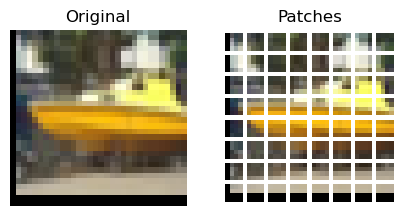

In [15]:
embedding = Embedding((3, 32, 32), (4, 4), 128)

images, labels = next(iter(train_loader))
patch_size = (4, 4)  # (H, W)

patches = embedding.patchify(images)
patch_grid = make_grid(
    patches[0].view(patches.shape[1], images.shape[1], patch_size[0], patch_size[1]),
    padding=1,
    normalize=True,
    pad_value=1,
    nrow=images.shape[3] // patch_size[0],
).cpu()

fig, axarr = plt.subplots(1, 2, figsize=(5, 5))
axarr[0].axis("off")
axarr[0].set_title("Original")
axarr[0].imshow(np.transpose(images[0]/2+0.5, (1, 2, 0)), cmap="gray")
axarr[1].axis("off")
axarr[1].set_title("Patches")
axarr[1].imshow(np.transpose(patch_grid, (1, 2, 0)))
plt.show()

## Self-Attention

Next, we implement the self-attention mechanism, which is defined as
$$
\text{softmax}\left(\frac{QK^\top}{\sqrt{d}}\right)V,
$$
where $Q$, $K$ and $V$ are computed by applying a dense layer to the input and $d$ is the number of features.
Complete the following module.
Note that this module is used for multi-head self-attention, so while the input to has `input_dim` dimensions, the attention is computed using `head_dim` dimensions and the single head outputs `head_dim` dimensions.

In [16]:
# POINTS: 4

class AttentionHead(nn.Module):
    def __init__(self, input_dim, head_dim):
        super().__init__()
        # YOUR CODE HERE
        # raise NotImplementedError()
        self.query = nn.Linear(input_dim, head_dim)
        self.key = nn.Linear(input_dim, head_dim)
        self.value = nn.Linear(input_dim, head_dim)
        self.scale = head_dim ** -0.5

    def forward(self, tokens):
        # YOUR CODE HERE
        # raise NotImplementedError()
        Q = self.query(tokens)
        K = self.key(tokens)
        V = self.value(tokens)
        
        scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale
        attn_weights = F.softmax(scores, dim=-1)
        attn_output = torch.matmul(attn_weights, V)
        
        return attn_output

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, n_heads, dim):
        super().__init__()
        if dim % n_heads != 0:
            raise ValueError('dim must be divisable by n_heads')
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = dim // n_heads

        self.heads = nn.ModuleList()
        for _ in range(self.n_heads):
            self.heads.append(AttentionHead(self.dim, self.head_dim))

        self.out_projection = nn.Linear(self.n_heads * self.head_dim, self.dim)

    def forward(self, tokens):
        result = []
        for seq in tokens:
            result.append(torch.hstack([head(seq) for head in self.heads]))
        result = torch.cat([torch.unsqueeze(r, dim=0) for r in result])
        return self.out_projection(result)

## Transformer

We will now construct the transformer using transformer blocks.
Each block performs the following steps:
$$ \mathbf z'_\ell = \text{MSA}(\text{LN}(\mathbf z_{\ell-1}))+\mathbf z_{\ell-1} $$
$$ \mathbf z_\ell = \text{MLP}(\text{LN}(\mathbf z'_\ell))+\mathbf z'_\ell $$

In [17]:
# POINTS: 2

class TransformerBlock(nn.Module):
    def __init__(self, n_heads, dim, mlp_dim):
        super().__init__()

        self.n_heads = n_heads
        self.dim = dim
        self.mlp_dim = mlp_dim

        # 1) Layer normalization 1
        self.ln1 = nn.LayerNorm(self.dim)

        # 2) Multi-head Self-Attention (MSA)
        self.msa = MultiHeadSelfAttention(self.n_heads, self.dim)

        # 3) Layer normalization 2
        self.ln2 = nn.LayerNorm(self.dim)

        # 4) MLP
        self.mlp = nn.Sequential(
            nn.Linear(self.dim, self.mlp_dim),
            nn.GELU(),
            nn.Linear(self.mlp_dim, self.dim),
        )

    def forward(self, tokens: torch.Tensor) -> torch.Tensor:
        # YOUR CODE HERE
        # raise NotImplementedError()
        tokens_norm = self.ln1(tokens)
        attn_output = self.msa(tokens_norm)
        tokens = tokens + attn_output  # Residual connection

        # Apply layer normalization and MLP
        tokens_norm = self.ln2(tokens)
        mlp_output = self.mlp(tokens_norm)
        tokens = tokens + mlp_output  # Residual connection

        return tokens

class Transformer(nn.Module):
    def __init__(self, num_layers, n_heads, dim, mlp_dim):
        super().__init__()
        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            layer = TransformerBlock(
                n_heads=n_heads,
                dim=dim,
                mlp_dim=mlp_dim,
            )
            self.layers.append(layer)

    def forward(self, tokens: torch.Tensor) -> torch.Tensor:
        for layer in self.layers:
            tokens = layer(tokens)
        return tokens

# ViT
Now combine everything together:
First create the tokens, then apply the transformer, extract the class token and apply the classification MLP to produce the final logits.

In [18]:
# POINTS: 3

class ViT(nn.Module):
    def __init__(
        self,
        im_shape,
        patch_size,
        dim=8,
        num_layers=1,
        n_heads=2,
        mlp_dim=8,
        out_dim=10,
    ):
        super().__init__()
        self.dim = dim
        self.mlp_dim = mlp_dim

        # 1) Embedding
        self.embedding = Embedding(
            im_shape=im_shape,
            patch_size=patch_size,
            out_dim=dim,
        )

        # 2) Transformer Encoder
        self.encoder = Transformer(
            num_layers=num_layers,
            n_heads=n_heads,
            dim=dim,
            mlp_dim=mlp_dim,
        )

        # 3) Classification MLP
        self.cls_mlp = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, out_dim),
        )

    def forward(self, images):
        # embedding -> encoding -> classification
        # YOUR CODE HERE
        # raise NotImplementedError()
        # Step 1: Compute embeddings
        tokens = self.embedding(images)
        
        # Step 2: Encode the tokens with the transformer
        encoded_tokens = self.encoder(tokens)
        
        # Step 3: Classification
        # Typically, only the first token (class token) is used for classification
        cls_token = encoded_tokens[:, 0]
        output = self.cls_mlp(cls_token)
        
        return output

Create a ViT-model and train it.
Do you find hyper-parameters which result in a test accuracy of more than 50%?
Note that this can take quite some time on CPU, depending on the parameters you choose.
Do fewer epochs to find good parameters.

In [19]:
# POINTS: 2

# YOUR CODE HERE
# raise NotImplementedError()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vit = ViT(    
    im_shape=(3, 32, 32),
    patch_size=(4, 4)
).to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit.parameters(), lr=0.001)

# Train the model
num_epochs = 10  # Adjust this value as needed
logdir = 'ViT'

train_model(
    model=vit,
    criterion=criterion,
    opt=optimizer,
    logdir=logdir,
    train_loader=train_loader,
    test_loader=test_loader,
    n_epochs=num_epochs
)

Epoch 1 | train loss: 2.147, train accuracy: 0.185, test loss: 1.999, test accuracy: 0.253, time: 0:02:35
Epoch 2 | train loss: 1.979, train accuracy: 0.255, test loss: 1.926, test accuracy: 0.287, time: 0:05:10
Epoch 3 | train loss: 1.930, train accuracy: 0.279, test loss: 1.879, test accuracy: 0.313, time: 0:07:46
Epoch 4 | train loss: 1.895, train accuracy: 0.292, test loss: 1.863, test accuracy: 0.313, time: 0:10:20
Epoch 5 | train loss: 1.875, train accuracy: 0.299, test loss: 1.841, test accuracy: 0.324, time: 0:13:00
Epoch 6 | train loss: 1.861, train accuracy: 0.305, test loss: 1.832, test accuracy: 0.330, time: 0:15:37
Epoch 7 | train loss: 1.850, train accuracy: 0.309, test loss: 1.813, test accuracy: 0.328, time: 0:18:12
Epoch 8 | train loss: 1.836, train accuracy: 0.312, test loss: 1.792, test accuracy: 0.335, time: 0:20:46
Epoch 9 | train loss: 1.824, train accuracy: 0.318, test loss: 1.792, test accuracy: 0.331, time: 0:23:22
Epoch 10 | train loss: 1.812, train accuracy: 